In [1]:
import numpy as np                  # Numpy is used for all kinds of mathematical stuff, especially related to matrices
import scipy.stats as sts           # SciPy is built specifically for statistical computing
import pandas as pd                 # Pandas is for reading in files and using dataframes
import matplotlib.pyplot as plt     # This package is used for the plotting framework, and can be used standalone
import seaborn as sns  # I use this package for nicer plots than the standard matplotlib plots
import math 
import scipy

In [2]:
#Import the data
raw_data = pd.read_csv("Assignment3_dataset.csv")

#### Transformation of data

In [3]:
#Transform the returns by subtracting sample mean and then multipying by 100.
for stock_name in raw_data.TICKER.unique():
    raw_data.loc[raw_data.TICKER == stock_name,'RET'] = (raw_data.RET - np.mean(raw_data.RET[raw_data.TICKER == stock_name]))*100
#checked whether transformation was done correctly by doing the calculation by hand for first obs. of every stock.



## Question 3

### Likelihood functions for both no leverage and leverage models

In [4]:
#llik function no leverage 
def llik_fun_GARCH_no_lev(theta,stock_name):
    x = stock_name.RET.iloc[0:2500]
    T=len(x);
    omega=theta[0]
    alpha=theta[1]
    beta=theta[2]
    lambda1=theta[3]

    # Filter Volatility
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(stock_name.RET.iloc[0:50]); #initialize volatility

    for t in range(0,T-1):
        sigma2[t+1] = omega + (alpha*(x[t]**2))/(1+((x[t]**2)/(lambda1*sigma2[t]))) + beta*sigma2[t]
 
    
    llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)

    
    return -np.mean(llik)

In [5]:
#llik function with leverage 
def llik_fun_GARCH_w_lev(theta,stock_name):
    x = stock_name.RET.iloc[0:2500]
    T=len(x);
    omega=theta[0]
    alpha=theta[1]
    beta=theta[2]
    delta=theta[3]
    lambda1=theta[4]

    # Filter Volatility
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(stock_name.RET.iloc[0:50]); #initialize volatility

    for t in range(0,T-1):
        if x[t] < 0:
            sigma2[t+1] = omega + ((alpha*(x[t]**2))+(delta*(x[t]**2)))/(1+((x[t]**2)/(lambda1*sigma2[t]))) + beta*sigma2[t]
        else:
            sigma2[t+1] = omega + (alpha*(x[t]**2))/(1+((x[t]**2)/(lambda1*sigma2[t]))) + beta*sigma2[t]
    
  
    llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)


    return -np.mean(llik)

In [6]:
#TEST LLIK FUNCTION NO LEVERAGE TO COMPARE WITH KO RESULTS IN PDF.
KO = raw_data.RET[raw_data.TICKER == 'KO'].reset_index()
KO = KO.drop(columns='index')

#par values (copied from PDF)
omega_TEST1   = 0.005665683
alpha_TEST1   = 0.09922153 
beta_TEST1    = 0.91055318 
lambda1_TEST1 = 5.5415955    
theta_TEST1 = np.array([omega_TEST1,
                       alpha_TEST1,
                       beta_TEST1,
                       lambda1_TEST1])

#apply function given the values and KO
llik_fun_GARCH_no_lev(theta_TEST1,KO)*-2500 #because -np.mean(LLIK) is returned

-3774.145968842645

In [7]:
#TEST LLIK FUNCTION WITH LEVERAGE TO COMPARE WITH KO RESULTS IN PDF.
KO = raw_data.RET[raw_data.TICKER == 'KO'].reset_index()
KO = KO.drop(columns='index')

#par values (copied from PDF)
omega_TEST2   = 0.007442577
alpha_TEST2   = 0.02670845
beta_TEST2    = 0.9217446
delta_TEST2   = 0.11266453
lambda1_TEST2 = 6.056328
theta_TEST2 = np.array([omega_TEST2,
                       alpha_TEST2,
                       beta_TEST2,
                       delta_TEST2,
                       lambda1_TEST2])

#apply function given the values and KO
llik_fun_GARCH_w_lev(theta_TEST2,KO)*-2500 #because -np.mean(LLIK) is returned

-3758.5960592298843

### Maximizing functions

In [11]:
#First,  create data frames to store the results of optimization
parameters_no_lev = pd.DataFrame(columns=['KO', 'PFE', 'JNJ', 'MRK'])
parameters_w_lev  = pd.DataFrame(columns=['KO', 'PFE', 'JNJ', 'MRK'])

In [12]:
#For model without leverage:
for stock_name in raw_data.TICKER.unique():
    dataframe_stock_name = pd.DataFrame(raw_data.RET[raw_data.TICKER == stock_name].reset_index())
    
    
    #list initial parameter values for the optimization and store them in vector
    omega_ini1   = np.var(dataframe_stock_name.RET.iloc[0:2500])/50
    alpha_ini1   = 0.02 
    beta_ini1    = 0.96 
    lambda1_ini1 = 5    
    theta_ini1 = np.array([omega_ini1,
                       alpha_ini1,
                       beta_ini1,
                       lambda1_ini1])
    
    #now, optimize llik function. 
    results = scipy.optimize.minimize(llik_fun_GARCH_no_lev, theta_ini1, args=(dataframe_stock_name), method='BFGS')
  
    print(f'Results for {stock_name}:')
    print(f'')
    print(f'parameter estimates {stock_name}:')
    print(f"omega  : {results.x[0]}")
    print(f"alpha  : {results.x[1]}")
    print(f"beta   : {results.x[2]}")
    print(f"lambda : {results.x[3]}")
    
    print(f'')
    
    print(f'log likelihood value {stock_name}:')
    print(results.fun*-2500)
    print('AIC') 
    print(2*len(theta_ini1)-2*(results.fun*2500))
    print('BIC')
    print(len(theta_ini1)*np.log(2500)-2*(results.fun*2500))
    print('exit flag:')
    print(results.success)
    print('message:')
    print(results.message)
   
    print(f'')
    print(f'')
    
    #store parameter values in just created dataframe
    parameters_no_lev[stock_name] = results.x

/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/1224429778.py:18: RuntimeWarning: invalid value encountered in sqrt
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)
/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/1224429778.py:18: RuntimeWarning: invalid value encountered in log
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)


Results for KO:

parameter estimates KO:
omega  : 0.005648375545051545
alpha  : 0.09934154514524406
beta   : 0.9104794102898055
lambda : 5.542324895690594

log likelihood value KO:
-3774.145880456341
AIC
-7540.291760912682
BIC
-7516.995576869256
exit flag:
True
message:
Optimization terminated successfully.




/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/1224429778.py:18: RuntimeWarning: invalid value encountered in sqrt
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)
/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/1224429778.py:18: RuntimeWarning: invalid value encountered in log
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)


Results for PFE:

parameter estimates PFE:
omega  : 0.028976491524802823
alpha  : 0.118736051163518
beta   : 0.8817457663010027
lambda : 6.174827469773313

log likelihood value PFE:
-4542.309156860948
AIC
-9076.618313721896
BIC
-9053.32212967847
exit flag:
True
message:
Optimization terminated successfully.




/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/1224429778.py:18: RuntimeWarning: invalid value encountered in sqrt
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)
/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/1224429778.py:18: RuntimeWarning: invalid value encountered in log
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)


Results for JNJ:

parameter estimates JNJ:
omega  : 0.013498786022142299
alpha  : 0.15553204818560248
beta   : 0.8526291628325565
lambda : 5.954033723077642

log likelihood value JNJ:
-3567.359346884069
AIC
-7126.718693768138
BIC
-7103.422509724713
exit flag:
True
message:
Optimization terminated successfully.




/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/1224429778.py:18: RuntimeWarning: invalid value encountered in sqrt
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)
/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/1224429778.py:18: RuntimeWarning: invalid value encountered in log
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)


Results for MRK:

parameter estimates MRK:
omega  : 0.049431528545158775
alpha  : 0.16251774308740088
beta   : 0.8394686743205337
lambda : 4.382438168438821

log likelihood value MRK:
-4685.030216725193
AIC
-9362.060433450386
BIC
-9338.76424940696
exit flag:
True
message:
Optimization terminated successfully.




In [ ]:
#For model with leverage:
for stock_name in raw_data.TICKER.unique():
    dataframe_stock_name = pd.DataFrame(raw_data.RET[raw_data.TICKER == stock_name].reset_index())
    
    #initial parameter values for models with leverage 
    omega_ini2   = np.var(dataframe_stock_name.RET.iloc[0:2500])/50 
    alpha_ini2   = 0.02 
    beta_ini2    = 0.96 
    delta_ini2   = 0
    lambda1_ini2 = 5    
    theta_ini2 = np.array([omega_ini2,
                       alpha_ini2,
                       beta_ini2,
                       delta_ini2,
                       lambda1_ini2])
    
    #now, optimize llik function. 
    results2 = scipy.optimize.minimize(llik_fun_GARCH_w_lev, theta_ini2, args=(dataframe_stock_name), method='BFGS')
  
    print(f'Results for {stock_name}:')
    print(f'')
    print(f'parameter estimates {stock_name}:')
    print(f"omega  : {results2.x[0]}")
    print(f"alpha  : {results2.x[1]}")
    print(f"beta   : {results2.x[2]}")
    print(f"delta  : {results2.x[3]}")
    print(f"lambda  : {results2.x[4]}")
    
    print(f'')
    
    print(f'log likelihood value {stock_name}:')
    print(results.fun*-2500)
    print(2*len(theta_ini2)-2*(results2.fun*2500))
    print('BIC')
    print(len(theta_ini2)*np.log(2500)-2*(results2.fun*2500))
    print('exit flag:')
    print(results.success)
    print(f'')
    print(f'')
    
    #store parameter values in just created dataframe
    parameters_w_lev[stock_name] = results2.x

/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/706215545.py:22: RuntimeWarning: invalid value encountered in sqrt
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)
/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/706215545.py:22: RuntimeWarning: invalid value encountered in log
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)


Results for KO:

parameter estimates KO:
omega  : 0.007415546356808641
alpha  : 0.027067434098402565
beta   : 0.921558759530108
delta  : 0.11256444662780245
lambda  : 6.018527347429182

log likelihood value KO:
-4685.030216725193
-7507.188532461802
BIC
-7478.068302407521
exit flag:
True




/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/706215545.py:22: RuntimeWarning: invalid value encountered in sqrt
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)
/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/706215545.py:22: RuntimeWarning: invalid value encountered in log
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)


Results for PFE:

parameter estimates PFE:
omega  : 0.01383124142599787
alpha  : 0.028186050857422904
beta   : 0.9197365148503099
delta  : 0.11151304911803483
lambda  : 6.002304485889427

log likelihood value PFE:
-4685.030216725193
-9053.509120519564
BIC
-9024.388890465283
exit flag:
True




/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/706215545.py:22: RuntimeWarning: invalid value encountered in sqrt
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)
/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/706215545.py:22: RuntimeWarning: invalid value encountered in log
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)


Results for JNJ:

parameter estimates JNJ:
omega  : 0.013212736545796593
alpha  : 0.04144256169132838
beta   : 0.8774473524105372
delta  : 0.1672910839934613
lambda  : 6.38371958404115

log likelihood value JNJ:
-4685.030216725193
-7088.281824093079
BIC
-7059.161594038797
exit flag:
True




/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/706215545.py:22: RuntimeWarning: invalid value encountered in sqrt
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)
/var/folders/q1/639n4btd13lfwpzm53tdj83m0000gn/T/ipykernel_10612/706215545.py:22: RuntimeWarning: invalid value encountered in log
  llik =math.lgamma((lambda1 + 1)/2) - math.lgamma(lambda1/2) - 1/2*np.log(lambda1) - 1/2*np.log(np.pi) - (lambda1 + 1)/2 * np.log(1+(((x/(sigma2**0.5))**2)/lambda1)) -1/2*np.log(sigma2)


In [13]:
parameters_no_lev

,KO,PFE,JNJ,MRK
0,0.005648,0.028976,0.013499,0.049432
1,0.099342,0.118736,0.155532,0.162518
2,0.910479,0.881746,0.852629,0.839469
3,5.542325,6.174827,5.954034,4.382438


In [ ]:
parameters_w_lev

## Question 4

In [14]:
vol_no_lev   = pd.DataFrame(columns=['KO', 'PFE', 'JNJ', 'MRK'])
vol_with_lev = pd.DataFrame(columns=['KO', 'PFE', 'JNJ', 'MRK'])

KO


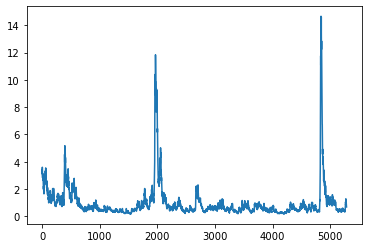

PFE


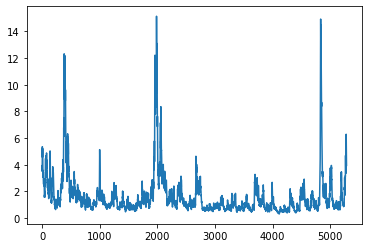

JNJ


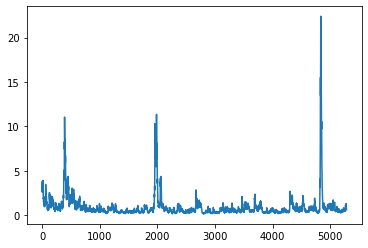

MRK


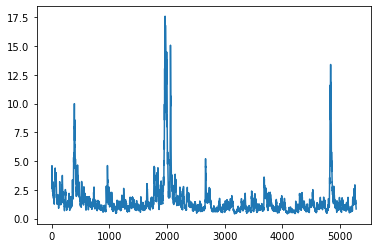

In [15]:
#Filtered volatilities for model without leverage
for stock_name in raw_data.TICKER.unique():
    dataframe_stock_name = pd.DataFrame(raw_data.RET[raw_data.TICKER == stock_name].reset_index())
    
    x = dataframe_stock_name.RET
    T= len(x)
    omega   =   parameters_no_lev[stock_name].loc[0]
    alpha   =   parameters_no_lev[stock_name].loc[1]
    beta    =   parameters_no_lev[stock_name].loc[2]
    lambda1 =   parameters_no_lev[stock_name].loc[3]


    sigma2 = np.zeros(T)
    sigma2[0] = np.var(dataframe_stock_name.RET.iloc[0:50]); #initialize volatility
    

    for t in range(0,T-1):
        sigma2[t+1] =  omega + (alpha*(x[t]**2))/(1+((x[t]**2)/(lambda1*sigma2[t]))) + beta*sigma2[t]
    
    vol_no_lev[stock_name] = sigma2

    plt.figure()
    plt.plot(sigma2)
    print(stock_name)
    # Show/save figure as desired.
    plt.show()

In [ ]:
sigma2_smaller_zero= 1 if sigma2[t]<0 else 0
lambda1_smaller_c = 1 lambda1<0.001 else 0

penalty = -100*T - 10000*T*( ((lambda-0.0001)**2) * lambda1_smaller_c + cov?((sigma2**2)*sigma2_smaller_zero))

if np.any(sigma2 < 0) or lambda1 < 0.0001:
    return(-penalty)
else return(-np.mean(llik))